In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms

# 定义变分自编码器（VAE）模型
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        
        # 编码器
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim * 2)  # 输出均值和方差
        )
        
        # 解码器
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # 计算标准差
        eps = torch.randn_like(std)  # 从标准正态分布中采样噪声
        z = mu + eps * std  # 重参数化技巧
        return z
    
    def forward(self, x):
        # 编码
        encoded = self.encoder(x)
        mu, logvar = torch.chunk(encoded, 2, dim=1)  # 将输出分割为均值和方差
        z = self.reparameterize(mu, logvar)  # 重参数化
        
        # 解码
        decoded = self.decoder(z)
        return decoded, mu, logvar

# 定义训练函数
def train_vae(model, train_loader, num_epochs, learning_rate):
    criterion = nn.MSELoss(reduction='mean')  # 二元交叉熵损失函数
    optimizer = optim.SGD(model.parameters(), lr=learning_rate,momentum=0.92)  # Adam优化器
    
    model.train()  # 设置模型为训练模式
    
    for epoch in range(num_epochs):
        total_loss = 0.0
        
        for images,_ in train_loader:
            images = images.to('cuda')
            images = images.view(images.size(0), -1)  # 展平输入图像
            
            optimizer.zero_grad()
            
            # 前向传播
            outputs, mu, logvar = model(images)
            
            # 计算重构损失和KL散度
            reconstruction_loss = criterion(outputs, images)
            kl_divergence = -5e-2 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
            
            # 计算总损失
            loss = reconstruction_loss + kl_divergence
            
            # 反向传播和优化
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        # 输出当前训练轮次的损失
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, total_loss / len(train_loader)))
    
    print('Training finished.')

# 示例用法
if __name__ == '__main__':
    # 设置超参数
    input_dim = 784  # 输入维度（MNIST图像的大小为28x28，展平后为784）
    hidden_dim = 256  # 隐层维度
    latent_dim = 32  # 潜在空间维度
    num_epochs = 20  # 训练轮次
    learning_rate = 5e-3  # 学习率
    pretrain = 1
    
    # 加载MNIST数据集
    train_set = torchvision.datasets.MNIST(root='./dataset', train=True, transform=transforms.ToTensor(), download=False)
    train_ld = torch.utils.data.DataLoader(dataset=train_set, batch_size=100, shuffle=True)
    
    # 创建VAE模型
    model = VAE(input_dim, hidden_dim, latent_dim).to('cuda')
    if pretrain:
        model.load_state_dict(torch.load('./checkpoint/VAE.pt'))
    
    # 训练VAE模型
    train_vae(model, train_ld, num_epochs, learning_rate)


Epoch [1/20], Loss: 0.0506
Epoch [2/20], Loss: 0.0506
Epoch [3/20], Loss: 0.0505
Epoch [4/20], Loss: 0.0505
Epoch [5/20], Loss: 0.0505
Epoch [6/20], Loss: 0.0506
Epoch [7/20], Loss: 0.0506
Epoch [8/20], Loss: 0.0506
Epoch [9/20], Loss: 0.0506
Epoch [10/20], Loss: 0.0506
Epoch [11/20], Loss: 0.0506
Epoch [12/20], Loss: 0.0506
Epoch [13/20], Loss: 0.0505
Epoch [14/20], Loss: 0.0505
Epoch [15/20], Loss: 0.0505
Epoch [16/20], Loss: 0.0506
Epoch [17/20], Loss: 0.0505
Epoch [18/20], Loss: 0.0506
Epoch [19/20], Loss: 0.0506
Epoch [20/20], Loss: 0.0506
Training finished.


In [82]:
torch.save(model.state_dict(),'./checkpoint/VAE.pt')

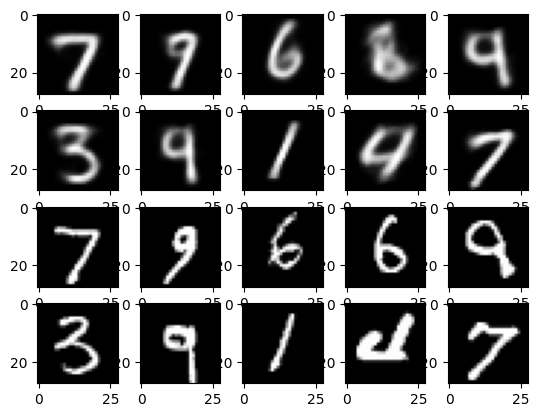

In [86]:
import matplotlib.pyplot as plt
import numpy as np
test_set = torchvision.datasets.MNIST(root='./dataset', train=False, transform=transforms.ToTensor(), download=False)
with torch.no_grad():
    for i,(y,_) in enumerate(test_set):
            y = y.to('cuda')
            #print(y.shape)
            y = y.view(y.shape[0], -1)
            #print(y.shape)
            y_pre,_,_ = model(y)
            if i%1000 == 0:
                y_pre = y_pre.view(1,1,28,28)
                y = y.view(1,1,28,28)
                y_pre = (y_pre.cpu().squeeze().numpy())
                y = (y.cpu().squeeze().numpy())
                #print(y_pre-y)
                plt.subplot(4,5,i//1000+1)
                plt.imshow(y_pre,cmap='gray')
                plt.subplot(4,5,i//1000+11)
                plt.imshow(y,cmap='gray')